## Flow to LAN distilation

__Goals:__ Combine the flexibility and training efficiency of normalizing flows with the inference speed of MLPs by distilling a trained flow-based density estimator into a likelihood approximation network (LAN).


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from functools import partial

import numpy as np
import torch as th
import jax.random as jrd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm

from pprint import pprint
from copy import deepcopy
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset

from sbi.analysis import pairplot
from sbi.inference import MNLE
from sbi.utils import BoxUniform

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from lanfactory.trainers import MLPJax, ModelTrainerJaxMLP

import hssm
from hssm.config import ModelConfig
from hssm.distribution_utils.dist import make_distribution, make_hssm_rv, make_likelihood_callable
from hssm.utils import decorate_atomic_simulator

from ssms.basic_simulators.simulator import simulator as ssm_simulator


wandb not available
wandb not available


In [2]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
th.manual_seed(seed)
key = jrd.PRNGKey(seed)

In [3]:
# Define numner of training simulations
num_sims_train = 50000

# Test parameter recovery
n_posterior_samples = 1000

# Define number of iid trials 
n_trials = 15

#### Step 1: Preparing the simulator

References: 
- https://github.com/lnccbrown/ssm-simulators/blob/main/notebooks/basic_tutorial.ipynb
- https://sbi-dev.github.io/sbi/v0.23.3/tutorials/00_getting_started/

In [4]:
def simulator(theta: Tensor) -> Tensor:
    """
    SBI expects simulator of that takes a tensor of param values [n_samples x param_dim]
      and return tensor of observations [n_samples x obs_dim].
    """
    xs = []
    for t in tqdm(theta):
        sim_out = ssm_simulator(
            model="ddm",
            theta={ "v": t[0].item(),
                    "a": t[1].item(),
                    "z": t[2].item(),
                    "t": t[3].item() },
            n_samples=1,
            smooth_unif=False,
        )
        rt = sim_out["rts"].squeeze()
        choice = sim_out["choices"].squeeze()

        # NOTE: there is some error when using [-1, 1] coding when training MNLE 
        # This should be fixed. For now, we convert to [0, 1] coding
        choice[choice == -1] = 0

        x = th.from_numpy(np.array([rt, choice]))
        xs.append(x)

    xs = th.stack(xs, dim=0).to(th.float32)
    return xs

In [5]:
# Define prior bounds on the parameters [v, a, z, t]
param_names = ["v", "a", "z", "t"]
param_lower_bounds = th.tensor([-3.0, 0.3, 0.1, 0.0])
param_upper_bounds = th.tensor([3.0, 2.5, 0.9, 2.0])
prior = BoxUniform(low=param_lower_bounds, high=param_upper_bounds)

In [6]:
float_bounds = [(low.item(), high.item()) for low, high in zip(param_lower_bounds, param_upper_bounds)]
param_bounds_dict = dict(zip(param_names, float_bounds))

In [7]:
# validate simulator and prior
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

100%|██████████| 1/1 [00:00<00:00, 1038.19it/s]


#### Step 2: Train density estimator using SBI 

References: 
- https://sbi-dev.github.io/sbi/v0.23.3/tutorials/00_getting_started/
- https://sbi-dev.github.io/sbi/v0.24.0/tutorials/Example_01_DecisionMakingModel/
- https://github.com/mackelab/mnle-for-ddms

In [8]:
# Generate MNLE training data
theta_train = prior.sample((num_sims_train,))
x_train = simulator(theta_train)

# Train MNLE 
trainer = MNLE(prior=prior)

100%|██████████| 50000/50000 [00:14<00:00, 3514.70it/s]


In [9]:
%%time
# Train MNLE
estimator = trainer.append_simulations(theta_train, x_train).train()

print('\nMNLE training time:')

 Neural network successfully converged after 98 epochs.
MNLE training time:
CPU times: user 3min 5s, sys: 1min 22s, total: 4min 28s
Wall time: 3min 19s


In [10]:
# Define theta obersvation for validation
theta_obs = th.tensor([[1.0, 1.5, 0.5, 0.3]])

In [11]:
# Test the likelihood by comparing emulator and simulator, for a known theta
synthetic_data = estimator.sample(sample_shape=(1000,), condition=theta_obs)
real_data = simulator(theta_obs.repeat(1000, 1))

# Fix the shapes of the sythentic data
synthetic_data = synthetic_data[:,0,:]
print('real_data.shape: ', real_data.shape)
print('synthetic data.shape: ', synthetic_data.shape)

100%|██████████| 1000/1000 [00:00<00:00, 2619.94it/s]

real_data.shape:  torch.Size([1000, 2])
synthetic data.shape:  torch.Size([1000, 2])


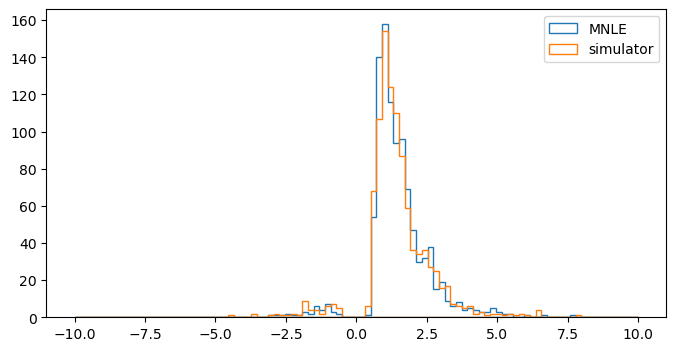

In [12]:
# Compare the histograms from real and sythetic data
plt.figure(figsize=(8, 4))
bins = th.linspace(-10, 10, 100)

synthetic_choice_mask = synthetic_data[:, 1] == 0
real_choice_mask = real_data[:, 1] == 0

plt.hist(-synthetic_data[synthetic_choice_mask, 0], bins=bins, histtype="step");
plt.hist(-real_data[real_choice_mask, 0], bins=bins, histtype="step");
plt.legend(["MNLE", "simulator"])
plt.hist(synthetic_data[~synthetic_choice_mask, 0], bins=bins, histtype="step", 
         color="C0");
plt.hist(real_data[~real_choice_mask, 0], bins=bins, histtype="step", 
         color="C1");

plt.show()

In [13]:
# Define MCMC parameters
mcmc_kwargs = dict(
    num_chains=5,
    warmup_steps=100,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

In [14]:
# Define parameters, simulate observation
x_obs = simulator(theta_obs.repeat(n_trials, 1))
mnle_posterior.set_default_x(x_obs);

100%|██████████| 15/15 [00:00<00:00, 1396.39it/s]


In [15]:
%%time
# Get posterior samples and MAP estimate
samples = mnle_posterior.sample((n_posterior_samples,))

print('\nMNLE posterior sampling time: ')

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]


MNLE posterior sampling time: 
CPU times: user 2min 28s, sys: 2min, total: 4min 29s
Wall time: 51 s


In [16]:
map = mnle_posterior.map().squeeze()

print('MAP estimate: \n', map)

MAP estimate: 
 tensor([1.0627, 1.9848, 0.6700, 0.3369])


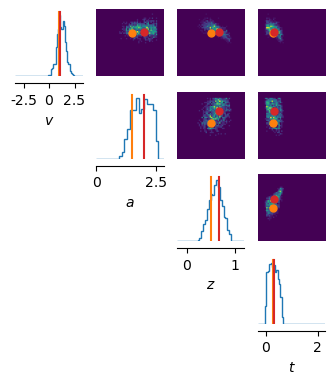

In [17]:
# Generate pair plot of posterior along with true and MAP parameters
#lower_bounds = th.tensor([-3.5, 0, 0, -.5])
#upper_bounds = th.tensor([3.5, 3, 1, 2.5])

lower_bounds = param_lower_bounds - .3
upper_bounds = param_upper_bounds + .3

fig, ax = pairplot(samples,
             limits=list(zip(lower_bounds, upper_bounds)),
             figsize=(4, 4),
             labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
             points=[theta_obs, map],
             );

/var/folders/px/fw8yx6952d98rglp3pvmk66w0000gn/T/ipykernel_78902/4083274417.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['kde_offdiag', 'kde_diag', 'contour_offdiag'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot([


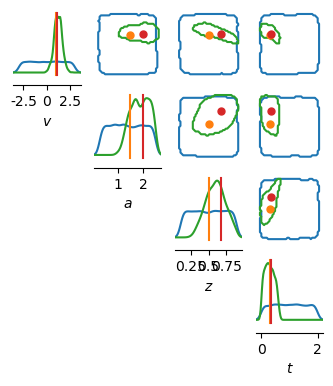

In [18]:
# Now plot pairplot with contours (obtained via KDE on the samples).
fig, ax = pairplot([
    prior.sample((10000,)),
    samples,
], 
    figsize=(4, 4),
    diag="kde",
    upper="contour", 
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
    points=[theta_obs, map],
);

#### Step 3: Distill flow into LAN

References:
- https://github.com/lnccbrown/LANfactory
- https://github.com/lnccbrown/LANfactory/blob/main/notebooks/basic_tutorial_jax_lan.ipynb

In [19]:
print(theta_train.shape)
print(x_train.shape)

torch.Size([50000, 4])
torch.Size([50000, 2])


In [20]:
# Get log prob evaluation for all the training data. These are the labels for the distillation.
with th.no_grad():
    log_p = estimator.log_prob(x_train.unsqueeze(0), condition=theta_train).squeeze(0)

# Convert back to [-1, 1] coding for LAN training
x_train_lan = deepcopy(x_train) 
x_train_lan[:, 1][x_train_lan[:, 1] == 0] = -1

# LANs learn the function f: [x, theta] -> log p(x | theta).
data = th.concat((theta_train, x_train_lan), dim=1)
labels = log_p.reshape(-1, 1)

In [21]:
print(data.shape)
print(labels.shape)

torch.Size([50000, 6])
torch.Size([50000, 1])


In [22]:
# Build DataLoaders
batch_size = 128
ds = TensorDataset(data, labels)
train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

# Tell the trainer how big each input is
train_dl.dataset.input_dim = data.shape[1]
valid_dl.dataset.input_dim = data.shape[1]

# Dummy placeholders so that .train_and_evaluate doesn’t crash on saving
train_dl.dataset.data_generator_config = {}
valid_dl.dataset.data_generator_config = {}
train_dl.dataset.file_ids = []
valid_dl.dataset.file_ids = []


# Train jax MLP with lanfactory
train_config = {"n_epochs": 50, "loss": "mse"}

mlp = MLPJax(
    layer_sizes=(64,64,1), 
    activations = ("relu","relu","linear"), 
    train=True, 
    train_output_type="logprob"
)

trainer = ModelTrainerJaxMLP(
    train_config, 
    mlp, 
    train_dl, 
    valid_dl, 
    seed=0
)

In [23]:
%%time
# Train LAN
final_state = trainer.train_and_evaluate(    
    output_folder="./jax_mlp_runs",
    output_file_id="lan_mlp",
    run_id="run1",
    wandb_on=False,
    save_all=False,
)

print('\nLAN training time: ')

Found folder:  .
Moving on...
Found folder:  ./jax_mlp_runs
Moving on...
Epoch: 0 of 50
Training - Step: 0 of 391 - Loss: 16.119469
Epoch 0/50 time: 0.2627382278442383s
Validation - Step: 0 of 391 - Loss: 0.52048033
Epoch 0/50 time: 0.14201807975769043s
Epoch: 0 / 50, test_loss: 1.3773343563079834
Epoch: 1 of 50
Training - Step: 0 of 391 - Loss: 0.38369083
Epoch 1/50 time: 0.12778401374816895s
Validation - Step: 0 of 391 - Loss: 0.56428635
Epoch 1/50 time: 0.10083198547363281s
Epoch: 1 / 50, test_loss: 1.2602382898330688
Epoch: 2 of 50
Training - Step: 0 of 391 - Loss: 0.4064765
Epoch 2/50 time: 0.12511777877807617s
Validation - Step: 0 of 391 - Loss: 0.8245822
Epoch 2/50 time: 0.1021261215209961s
Epoch: 2 / 50, test_loss: 1.1228625774383545
Epoch: 3 of 50
Training - Step: 0 of 391 - Loss: 1.3183761
Epoch 3/50 time: 0.13413596153259277s
Validation - Step: 0 of 391 - Loss: 1.1654141
Epoch 3/50 time: 0.10099196434020996s
Epoch: 3 / 50, test_loss: 1.0216610431671143
Epoch: 4 of 50
Trainin

#### Step 4: posterior inference using HSSM

References: 
- https://github.com/lnccbrown/HSSM
- https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/

In [24]:
jax_logp, _ = mlp.make_forward_partial(
    seed=seed,
    input_dim=4 + 2,  # n-parameters (v,a,z,t) + n-data (rts and choices)
    state="./jax_mlp_runs/run1_lan_lan_mlp__train_state.jax",
    add_jitted=True,
)

In [25]:
# Testing the signature of the JAX function 1
jax_logp(np.tile(np.array([1.0, 1.5, 0.5, 0.3, 1.6, 1.0]), (n_trials, 1)))

Array([[-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781],
       [-0.87828781]], dtype=float64)

In [26]:
# Testing the signature of the JAX function 2
n_dim_model_parameters = 4
n_dim_data = 2
in_ = jnp.zeros((n_trials, n_dim_model_parameters + n_dim_data))
out = jax_logp(in_)
print(out.shape)

(15, 1)


In [27]:
def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
    """ Wrap a simulator function to match HSSM's expected interface. """
    out = simulator_fun(
        theta=theta,
        model=model,
        n_samples=n_samples,
        random_state=random_state,
        **kwargs,
    )
    return np.column_stack([out["rts"], out["choices"]])

my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=ssm_simulator, model="ddm", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="ddm", choices=[-1, 1], obs_dim=2
)(my_wrapped_simulator)

In [ ]:
theta_obs_np = theta_obs[0].numpy()
decorated_simulator(
    theta=np.tile(theta_obs_np, (n_trials, 1)), random_state=42
)

array([[ 2.12210941,  1.        ],
       [ 2.6890626 ,  1.        ],
       [ 1.28667963,  1.        ],
       [ 1.16390681,  1.        ],
       [ 1.42591691,  1.        ],
       [ 1.14748347,  1.        ],
       [ 1.47392309,  1.        ],
       [ 0.88049531, -1.        ],
       [ 1.78516912,  1.        ],
       [ 1.20256472,  1.        ],
       [ 0.79170984,  1.        ],
       [ 2.30563331,  1.        ],
       [ 0.99010974,  1.        ],
       [ 1.68477559,  1.        ],
       [ 2.6796515 ,  1.        ]])

In [ ]:
# Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=param_names
)

# Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=jax_logp,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[False, False, False, False],
    params_only=False,
)

# Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=param_names,
    bounds=param_bounds_dict,
)

'\nCustomDistribution = make_distribution(\n    rv=CustomRV,\n    loglik=logp_jax_op,\n    list_params=param_names,\n    bounds=dict(v=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),\n)\n'

In [30]:
mcmc_kwargs

{'num_chains': 5,
 'warmup_steps': 100,
 'method': 'slice_np_vectorized',
 'init_strategy': 'proposal'}

In [31]:
# simulate some data from the model
obs_ddm = hssm.simulate_data(
    theta = dict(
            v=theta_obs[0][0].item(), 
            a=theta_obs[0][1].item(),     
            t=theta_obs[0][2].item(), 
            z=theta_obs[0][3].item()
    ), 
    model="ddm", 
    size=10
)

# Test via basic pymc model
with pm.Model() as model:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Uniform("a", lower=0.5, upper=3.0)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=0.5, beta=1.0)
    CustomDistribution("custom", v=v, a=a, z=z, t=t, observed=obs_ddm.values)
    
with model:
    idata = pm.sample(draws=n_posterior_samples, 
                      tune=mcmc_kwargs['warmup_steps'], 
                      chains=mcmc_kwargs['num_chains'], 
                      nuts_sampler="numpyro"
            )

sample: 100%|██████████| 1100/1100 [00:03<00:00, 325.06it/s, 127 steps of size 8.26e-03. acc. prob=0.77]


In [ ]:
pprint(dict(zip(param_names, theta_obs.squeeze())))

{'a': tensor(1.5000), 't': tensor(0.3000), 'v': tensor(1.), 'z': tensor(0.5000)}


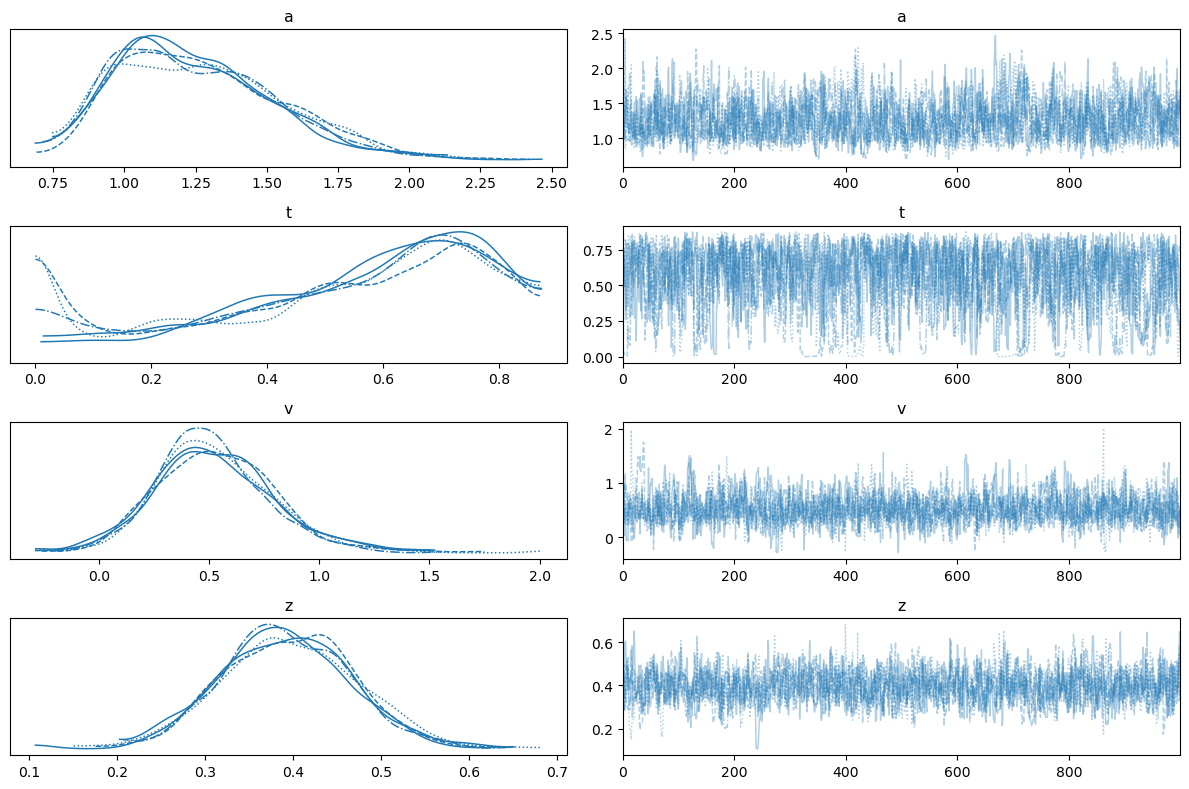

In [42]:
# Plot the trace of the posterior samples
az.plot_trace(idata);
plt.tight_layout()


In [ ]:
# Define model config
my_custom_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=param_names,
    bounds=param_bounds_dict,
    rv=decorated_simulator,
    backend="jax",
    choices=[-1, 1],
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


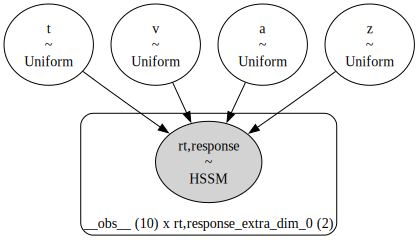

In [34]:
# Define the HSSM model
model = hssm.HSSM(
    data=obs_ddm,
    model="lan_distillation",  
    model_config=my_custom_model_config,
    loglik_kind="approx_differentiable",
    loglik=jax_logp,
    p_outlier=0,
)

model.graph()

In [35]:
%%time
# Test sampling
model.sample(draws=n_posterior_samples, 
             tune=mcmc_kwargs['warmup_steps'], 
             chains=mcmc_kwargs["num_chains"], 
             nuts_sampler="numpyro", 
             discard_tuned_samples=False
    )   

print('\nHSSM sampling time: ')

Using default initvals. 



sample: 100%|██████████| 1100/1100 [00:11<00:00, 95.85it/s, 1023 steps of size 3.79e-03. acc. prob=0.84] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 5000/5000 [00:00<00:00, 13194.46it/s]


HSSM sampling time: 
CPU times: user 32 s, sys: 6.12 s, total: 38.2 s
Wall time: 27.3 s


In [43]:
pprint(dict(zip(param_names, theta_obs.squeeze())))

{'a': tensor(1.5000), 't': tensor(0.3000), 'v': tensor(1.), 'z': tensor(0.5000)}


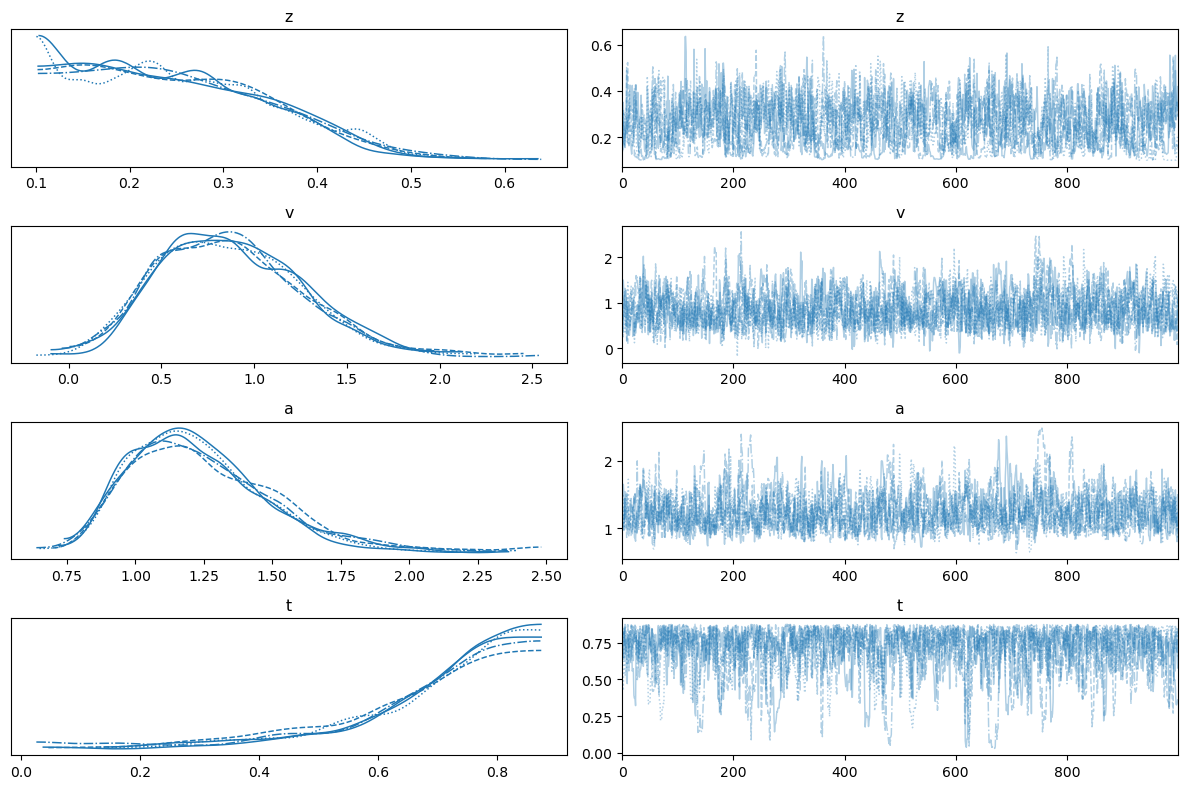

In [ ]:
axes = az.plot_trace(model.traces)
plt.tight_layout()

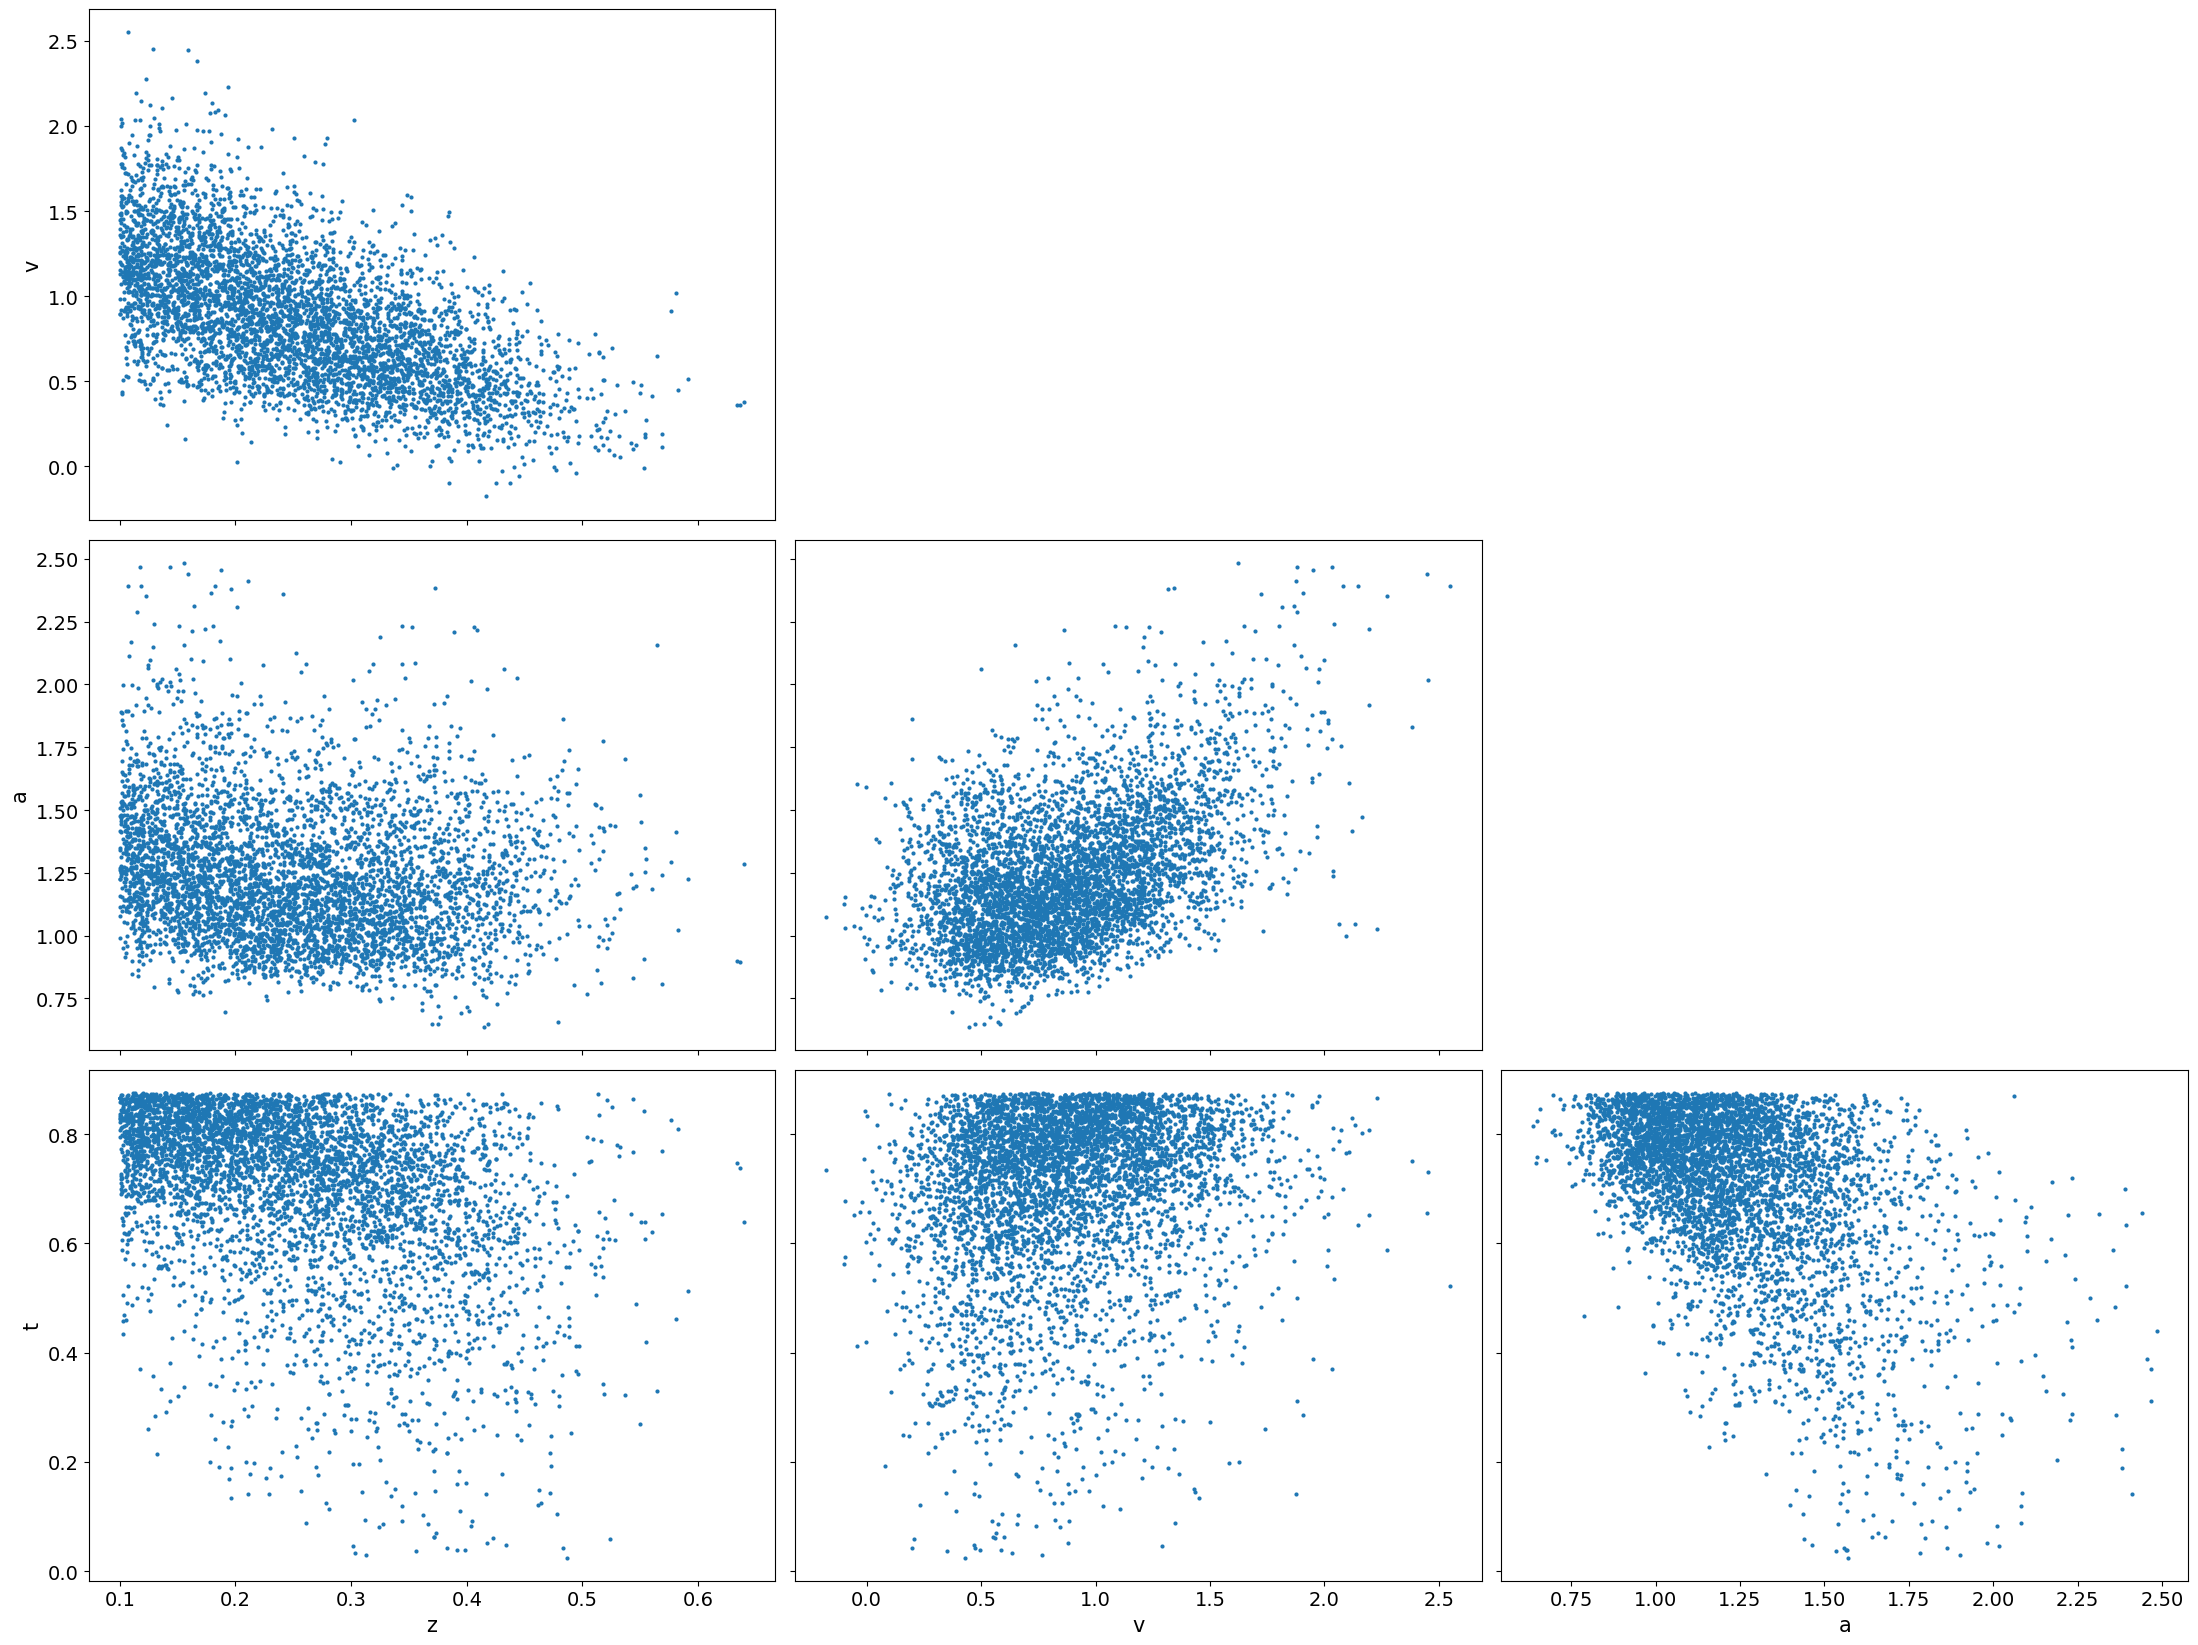

In [44]:
az.plot_pair(model.traces)
plt.tight_layout()